# MPS using the deesse wrapper - basics

## Main points addressed:
- launching deesse
- simple deesse simulations of a categorical variable, with hard data points
- basic statistics on the results
- deesse simulation using pyramids (multi-resolution)
- usage of function for plotting 2D and 3D images

## Import what is required

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

# import package 'geone'
import geone as gn

In [2]:
# Show version of python and version of geone
import sys 
print(sys.version_info)
print('geone version: ' + gn.__version__)

sys.version_info(major=3, minor=10, micro=6, releaselevel='final', serial=0)
geone version: 1.1.5


### Remark
The matplotlib figures can be visualized in *interactive* mode:
- `%matplotlib notebook`: enable interactive mode
- `%matplotlib inline`: disable interactive mode

## Training image (TI)

The file `ti.gslib` has the following format:
```    
    Nx Ny Nz [Sx Sy Sz [Ox Oy Oz]]
    nvar
    name_of_variable_1
    ...
    name_of_variable_nvar
    Z1(0)    ... Znvar(0)
    ...
    Z1(Ng-1) ... Znvar(Ng-1)
```
The file is read using the function `geone.img.readImageGslib`, which returns an *image* (class `geone.img.Img`).

In [3]:
ti = gn.img.readImageGslib('ti.gslib')

Note that a variable can contain missing values. Such values ared coded with `np.nan`. The string 'nan' in a file stands for a missing value. Additionally, if a specific value is used in the file to identify missing values, this specific value can be passed to the function `geone.img.readImageGslib` through the keyword argument `missing_value`, e.g.: `ti = geone.img.readImageGslib('ti.gslib', missing_value=-9999999)`.

## Plot the image: function `geone.imgplot.drawImage2D`

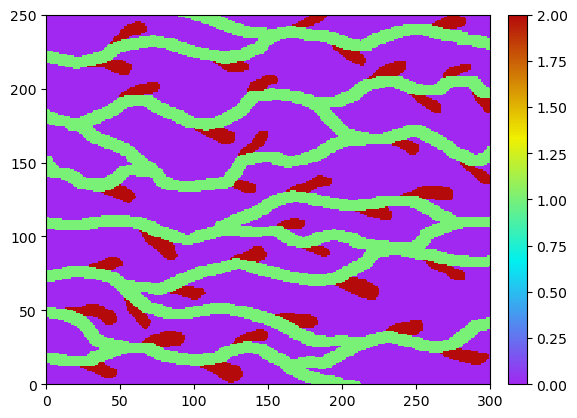

In [4]:
plt.figure()
gn.imgplot.drawImage2D(ti)
plt.show()

One can customize the output using options. For example, one can specify that it is a categorical image and specify the color used for each category.

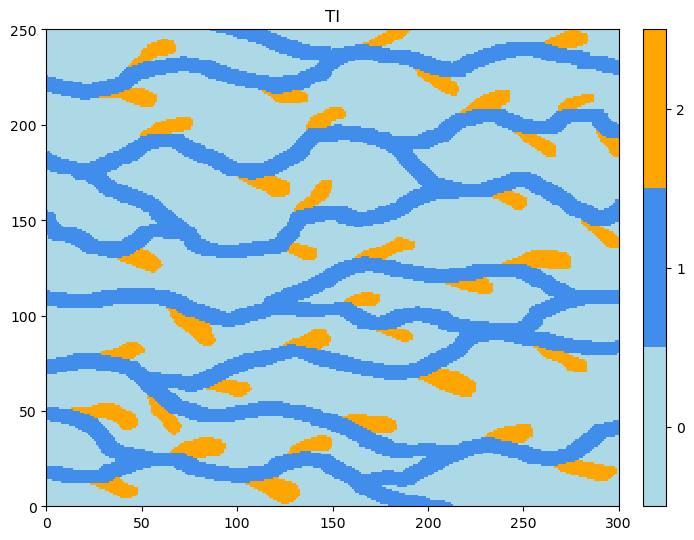

In [5]:
col = ['lightblue', [x/255. for x in ( 65, 141, 235)], 'orange']

plt.figure(figsize=(8,8))
gn.imgplot.drawImage2D(ti, categ=True, categCol=col, title='TI')
plt.show()

## Hard data (point set)

The file `hd.gslib` has the following format:
```    
    npoint
    nvar+3
    name_for_x_coordinate
    name_for_y_coordinate
    name_for_z_coordinate
    name_of_variable_1
    ...
    name_of_variable_nvar
    x(1)      y(1)      z(1)      Z1(1)      ... Znvar(1)
    ...
    x(npoint) y(npoint) z(npoint) Z1(npoint) ... Znvar(npoint)
```
The file is read using the function `geone.img.readPointSetGslib`, which returns a *point set* (class `geone.img.PointSet`).

*Note:* missing values are treated in the same manner as in images (`geone.img.Img`) and in the function `geone.img.readPointSetGslib`.

In [6]:
hd = gn.img.readPointSetGslib('hd.gslib')
hd.varname

['x', 'y', 'z', 'code']

In [7]:
hd.val

array([[10.5, 14.5, 60.5, 45.5, 17.5, 52.5, 45.5],
       [20.5, 21.5, 32.5, 55.5, 75.5, 80.5, 97.5],
       [ 0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5],
       [ 2. ,  2. ,  1. ,  0. ,  1. ,  0. ,  0. ]])

## Input structure for deesse (class `geone.deesseinterface.DeesseInput`)
The variable name for the hard data (in `hd.varname`) and for the simulated variable (keyword argument `varname` below) should be the same, otherwise, the hard data will be ignored. Moreover, the hard data locations should be in the simulation grid, which is described by its dimensions (number of cells) in each direction, the cell unit in each direction, and the origin (the *corner* of the grid cell with the minimal x, y, z coordinates). Hard data points out of the simulation grid are ignored.  

The hard data can be passed to deesse through a *point set*, i.e. a class `geone.img.PointSet` (keyword argument `dataPointSet`, as below) or through an *image*, i.e. a class `geone.img.Img` (keyword argument `dataImage`, not illustrated here), and can contain missing (uninformed) data (`np.nan`).

The type of distance for computing the dissimilarity between patterns is controlled by the keyword argument `distanceType`: 
- `0` or `'categorical'`: proportion of non-matching nodes (default)
- `1` or `'continuous'`: $L_1$ distance
- `2`: $L_2$ distance
- `3`: $L_p$ distance (requires real positive parameter p given in parameter `powerLpDistance`)
- `4` :$L_\infty$ distance

In [8]:
nreal = 20
deesse_input = gn.deesseinterface.DeesseInput(
    nx=100, ny=100, nz=1,       # dimension of the simulation grid (number of cells)
    sx=1.0, sy=1.0, sz=1.0,     # cells units in the simulation grid (here are the default values)
    ox=0.0, oy=0.0, oz=0.0,     # origin of the simulation grid (here are the default values)
    nv=1, varname='code',       # number of variable(s), name of the variable(s)
    nTI=1, TI=ti,               # number of TI(s), TI (class gn.deesseinterface.Img)
    dataPointSet=hd,            # hard data (optional)
    distanceType='categorical', # distance type: proportion of mismatching nodes (categorical var., default)
    nneighboringNode=24,        # max. number of neighbors (for the patterns)
    distanceThreshold=0.05,     # acceptation threshold (for distance between patterns)
    maxScanFraction=0.25,       # max. scanned fraction of the TI (for simulation of each cell)
    npostProcessingPathMax=1,   # number of post-processing path(s)
    seed=444,                   # seed (initialization of the random number generator)
    nrealization=nreal)         # number of realization(s)

## Launching deesse

### Launch deesse: function `geone.deesseinterface.deesseRun`
The function `geone.deesseinterface.deesseRun` launches deesse. The code runs in parallel (based on *OpenMP*). The number of threads used can be specified by the keyword argument `nthreads`. Specifying a number `-n`, negative or zero, means that the total number of cpus of the system (retrieved by `os.cpu_count()`) except `n` (but at least one) will be used. By default: `nthreads=-1`.

*Remark:* the keyword argument `verbose` allows to control what is displayed, `verbose=0`: minimal display, `verbose=1` (default): version and warning(s) encountered, `verbose=2`: version, progress, and warning(s) encountered. Note that due to *buffering*, progress might not be displayed immediately and then could be useless.

In [9]:
t1 = time.time() # start time
deesse_output = gn.deesseinterface.deesseRun(deesse_input, nthreads=8)
t2 = time.time() # end timec
print('Elapsed time: {:.2g} sec'.format(t2-t1))

DeeSse running... [VERSION 3.2 / BUILD NUMBER 20221014 / OpenMP 8 thread(s)]
* checking out license OK.
DeeSse run complete
Elapsed time: 2.3 sec


## Retrieve the results (and display)
The function `geone.deesseinterface.deesseRun` returns the dictionary

`deesse_output = {'sim':sim, 'path':path, 'error':error, tiGridNode':tiGridNode, 'tiIndex':tiIndex, 'nwarning':nwarning, 'warnings':warnings}`

The realizations are stored in `deesse_output['sim']`, a 1-dimensional array of *images* (class `geone.img.Img`) of size `deesse_input.nrealization`, `deesse_output['sim'][i]` being the i-th realization.

The total number of warning(s) encountered during the simulation are stored in `deesse_output['nwarning']` (*int*), and all the distinct warning messages are stored in `deesse_output['warnings']` (a list, possibly empty).

Moreover, additional information can be retrieved in output: the simulation path map (index in the simulation path), the error map (error for the retained candidate), the TI grid node index map (index of the grid node of the retained candidate in the TI) and the TI index map (index of the TI used (makes sense if number of TIs, *deesse_input.nTI*, is greater than 1)). These maps are images with the simulation grid as grid (support), and can be retrieved in output in `deesse_output['path']`, `deesse_output['error']`, `deesse_output['tiGridNode']` and `deesse_output['tiIndex']` respectively. However, these ouputs are set to `None` by default. (A further example illustrates that.)

In [10]:
# Total number of warning(s), and warning messages
deesse_output['nwarning'], deesse_output['warnings']

(0, [])

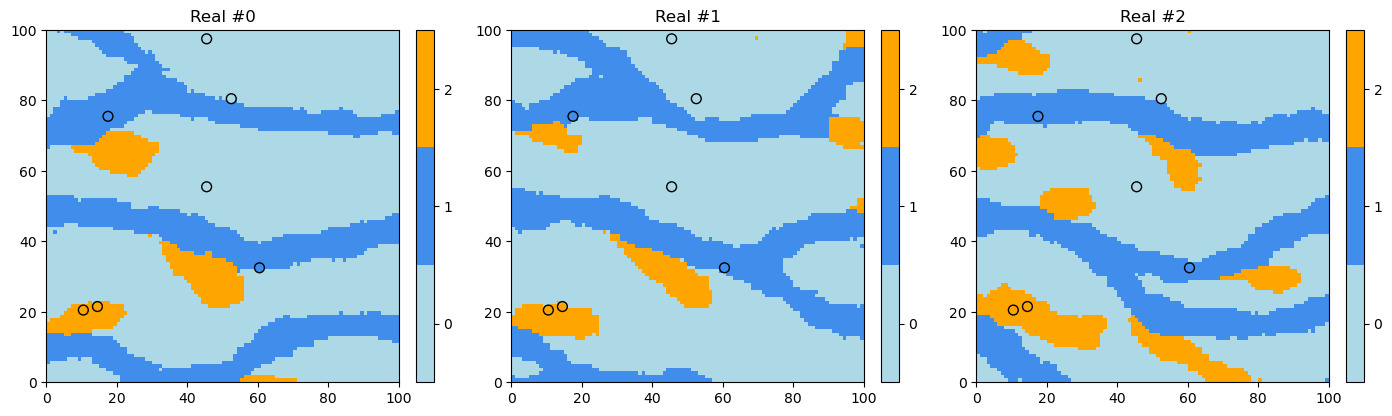

In [11]:
# Retrieve the realizations
sim = deesse_output['sim']

# Display
import matplotlib.colors
hd_col=[matplotlib.colors.to_rgba(col[int(v)]) for v in hd.val[3]] # colors (converted to 'rgba') 
                                                                   # of hard data points

plt.subplots(1, 3, figsize=(17,5)) # 1 x 3 sub-plots
for i in range(3):
    plt.subplot(1, 3, i+1) # select next sub-plot
    gn.imgplot.drawImage2D(sim[i], categ=True, categCol=col, title='Real #{}'.format(i)) # plot real #i
    plt.scatter(hd.x(), hd.y(), marker='o', s=50, 
                color=hd_col, edgecolors='black', linewidths=1) # add hard data points
plt.show()

## Do some statistics on the realizations
The function `geone.img.imageCategProp(im, categ)` allows to compute the pixel-wise proportions of given categories in the list `categ` over all the variables of the image `im`. 

An image with `nreal` variables, each one corresponding to one realization, can be defined (from the array of realizations) using the function `geone.img.gatherImages`.

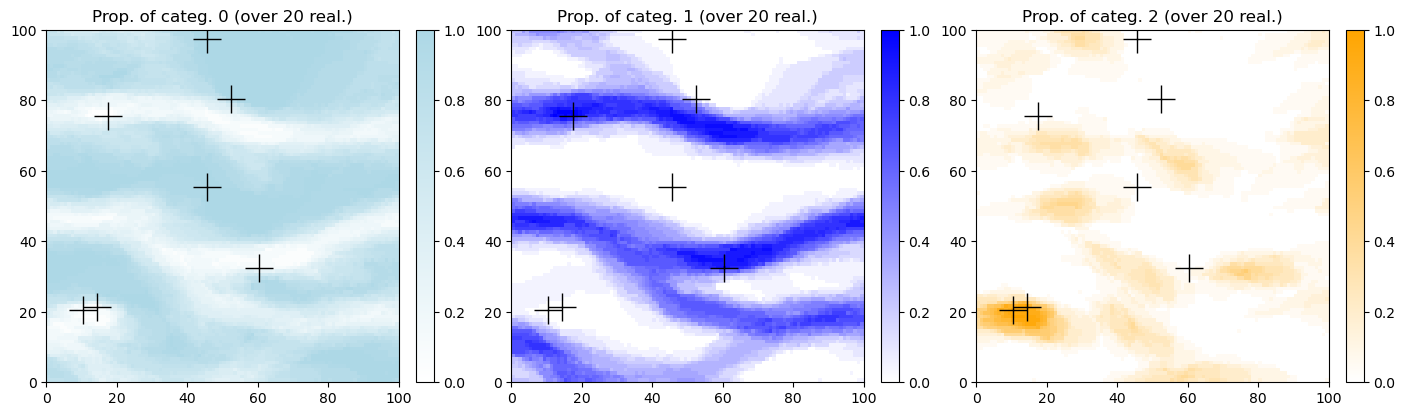

In [12]:
# Gather the nreal realizations into one image
all_sim = gn.img.gatherImages(sim) # all_sim is one image with nreal variables

# Do statistics over all the realizations: compute the pixel-wise proportion for the given categories
all_sim_stats = gn.img.imageCategProp(all_sim, [0, 1, 2])

prop_col=['lightblue', 'blue', 'orange'] # colors for the proportion maps
cmap = [gn.customcolors.custom_cmap(['white', c]) for c in prop_col]

# Display
plt.subplots(1, 3, figsize=(17,5)) # 1 x 3 sub-plots
for i in range(3):
    plt.subplot(1, 3, i+1) # select next sub-plot
    gn.imgplot.drawImage2D(all_sim_stats, iv=i, cmap=cmap[i],
                           title='Prop. of categ. {} (over {} real.)'.format(i, nreal))
    plt.plot(hd.x(), hd.y(), '+', markersize=20, c='black') # add hard data points
plt.show()

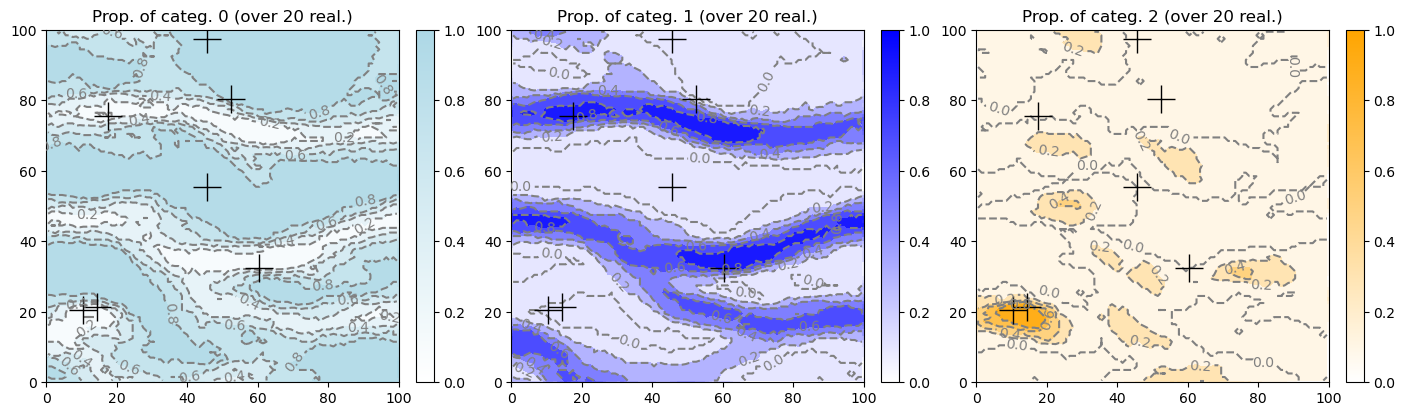

In [13]:
# Display with other styles (level (iso-value) curves)
plt.subplots(1, 3, figsize=(17,5)) # 1 x 3 sub-plots
for i in range(3):
    plt.subplot(1, 3, i+1) # select next sub-plot
    gn.imgplot.drawImage2D(all_sim_stats, iv=i, cmap=cmap[i], 
                           contourf=True, # fill between level (iso-value) curves
                           contour=True,  # draw level (iso-value) curves
                           levels=5, #levels=np.arange(0.0, 1.1, 0.2), # specify levels (iso-values)
                           contour_clabel=True, # draw value on level curves
                           contour_kwargs={'linestyles':'dashed', 'colors':'gray'},
                           contour_clabel_kwargs={'fontsize':10, 'inline':1},
                           title='Prop. of categ. {} (over {} real.)'.format(i, nreal))
    plt.plot(hd.x(), hd.y(), '+', markersize=20, c='black') # add hard data points
plt.show()

## Simulations using pyramids
Enabling pyramids implies multi-resolution simulations, which can help to better reproduce the spatial structures. It consists in considering lower resolutions of the TI and the simulation grid.  

### Parameters for pyramids 
#### Class `geone.deesseinterface.PyramidGeneralParameters` and class `geone.deesseinterface.PyramidParameters`
Using pyramids requires to define:
- General parameters (class `geone.deesseinterface.PyramidGeneralParameters`):
    - the number of pyramid levels (`npyramidLevel`) additional to the original simulation grid
    - the reduction factors along each axis direction (`kx`, `ky`, `kz`, list of length `npyramidLevel`): the integers `kx[i]`, `ky[i]`, `kz[i]` are these factors between the level `i` and the level `i+1` (the number of cells in each direction are respectively divided by these factors), the simulation grid being the level `0`, and the lowest resolution being the level `npyramidLevel`. (A factor set to zero means that no reduction is made along the corresponding direction.)
- Parameters for each variable (one variable in this example (univariate simulation)):
    - the number of levels (`nlevel`, should be equal to `npyramidLevel` above)
    - the type of pyramid (`pyramidType`), which depends on the type of the variable
    
Note: in the example below, the pyramid type is set to `categorical_auto`: one pyramid for the indicator variable of each category except one is built and used. 

In [14]:
pyrGenParams = gn.deesseinterface.PyramidGeneralParameters(
    npyramidLevel=2,                 # number of pyramid levels, additional to the simulation grid
    kx=[2, 2], ky=[2, 2], kz=[0, 0]  # reduction factors from one level to the next one
                                     #    (kz=[0, 0]: do not apply reduction along z axis)
)

pyrParams = gn.deesseinterface.PyramidParameters(
    nlevel=2,                      # number of levels
    pyramidType='categorical_auto' # type of pyramid (accordingly to categorical variable in this example)
)

### Fill the input structure for deesse and launch deesse

In [15]:
deesse_input = gn.deesseinterface.DeesseInput(
    nx=100, ny=100, nz=1,
    nv=1, varname='code',
    nTI=1, TI=ti,
    dataPointSet=hd,
    distanceType='categorical',
    nneighboringNode=24,
    distanceThreshold=0.05,
    maxScanFraction=0.25,
    pyramidGeneralParameters=pyrGenParams, # set pyramid general parameters
    pyramidParameters=pyrParams,           # set pyramid parameters for each variable
    npostProcessingPathMax=1,
    seed=444,
    nrealization=nreal)

# Run deesse 
deesse_output = gn.deesseinterface.deesseRun(deesse_input)

DeeSse running... [VERSION 3.2 / BUILD NUMBER 20221014 / OpenMP 19 thread(s)]
* checking out license OK.
DeeSse run complete


### Results

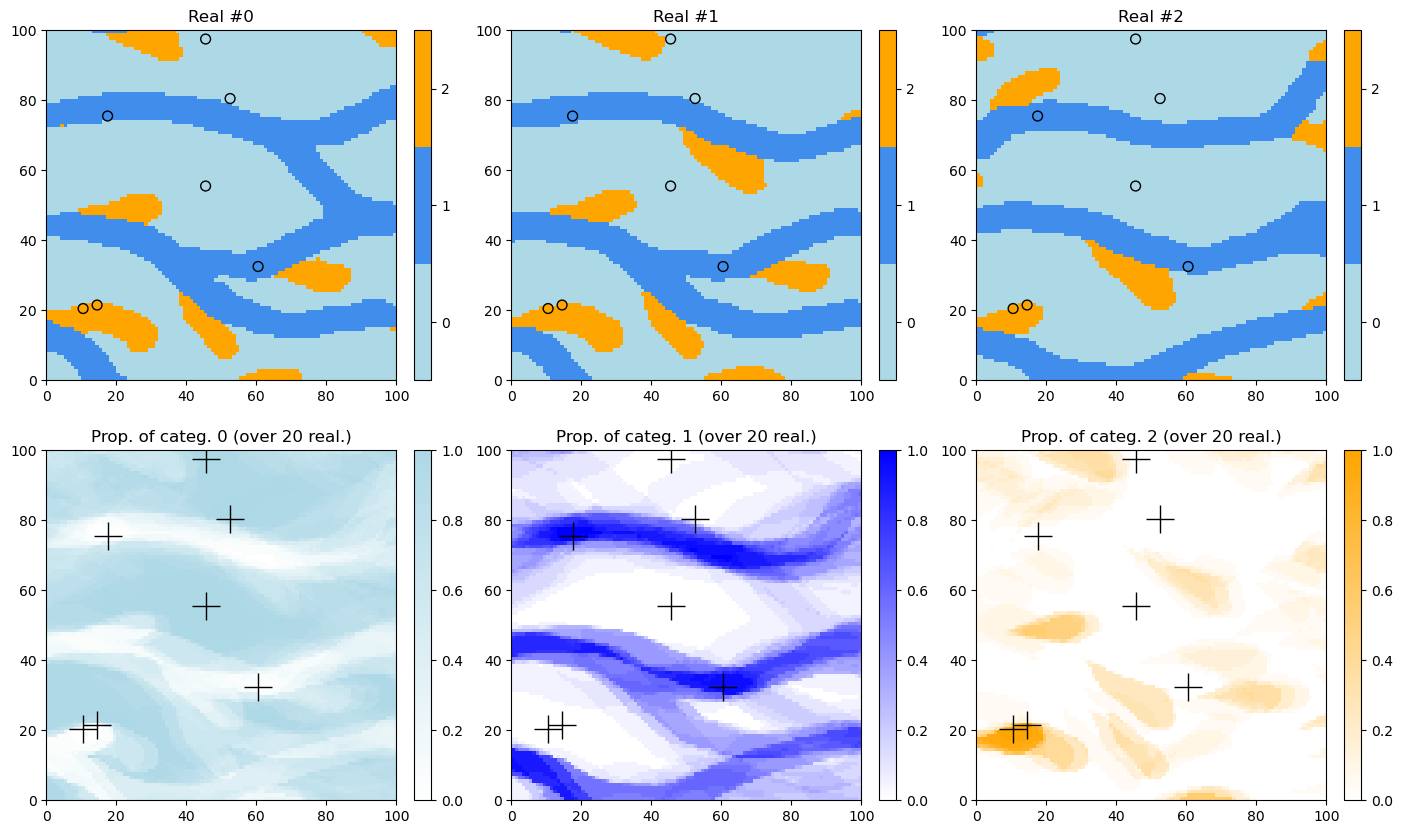

In [16]:
# Retrieve the realizations
sim = deesse_output['sim']

# Gather the nreal realizations into one image
all_sim = gn.img.gatherImages(sim) # all_sim is one image with nreal variables

# Do statistics over all the realizations: compute the pixel-wise proportion for the given categories
all_sim_stats = gn.img.imageCategProp(all_sim, [0, 1, 2])

# Display
plt.subplots(2, 3, figsize=(17,10)) # 2 x 3 sub-plots
for i in range(3):
    plt.subplot(2, 3, i+1) # select next sub-plot
    gn.imgplot.drawImage2D(sim[i], categ=True, categCol=col, title='Real #{}'.format(i)) # plot real #i
    plt.scatter(hd.x(), hd.y(), marker='o', s=50, 
                color=hd_col, edgecolors='black', linewidths=1) # add hard data points
for i in range(3):
    plt.subplot(2, 3, i+4) # select next sub-plot
    gn.imgplot.drawImage2D(all_sim_stats, iv=i, cmap=cmap[i], 
                           title='Prop. of categ. {} (over {} real.)'.format(i, nreal))
    plt.plot(hd.x(), hd.y(), '+', c='black', markersize=20) # add hard data points
plt.show()

## Simulations using pyramids (2)
Here the pyramid type is set to `categorical_to_continuous`: the pyramid is built for one continuous variable derived from the categorical variable (accounting for the connections between adjacent nodes).

In [17]:
# Deesse input
pyrParams = gn.deesseinterface.PyramidParameters(
    nlevel=2,
    pyramidType='categorical_to_continuous' # type of pyramid (accordingly to categ. variable in this example)
)

deesse_input = gn.deesseinterface.DeesseInput(
    nx=100, ny=100, nz=1,
    nv=1, varname='code',
    nTI=1, TI=ti,
    dataPointSet=hd,
    distanceType='categorical',
    nneighboringNode=24,
    distanceThreshold=0.05,
    maxScanFraction=0.25,
    pyramidGeneralParameters=pyrGenParams,
    pyramidParameters=pyrParams,
    npostProcessingPathMax=1,
    seed=444,
    nrealization=nreal)

# Run deesse 
deesse_output = gn.deesseinterface.deesseRun(deesse_input)

DeeSse running... [VERSION 3.2 / BUILD NUMBER 20221014 / OpenMP 19 thread(s)]
* checking out license OK.
DeeSse run complete


### Results

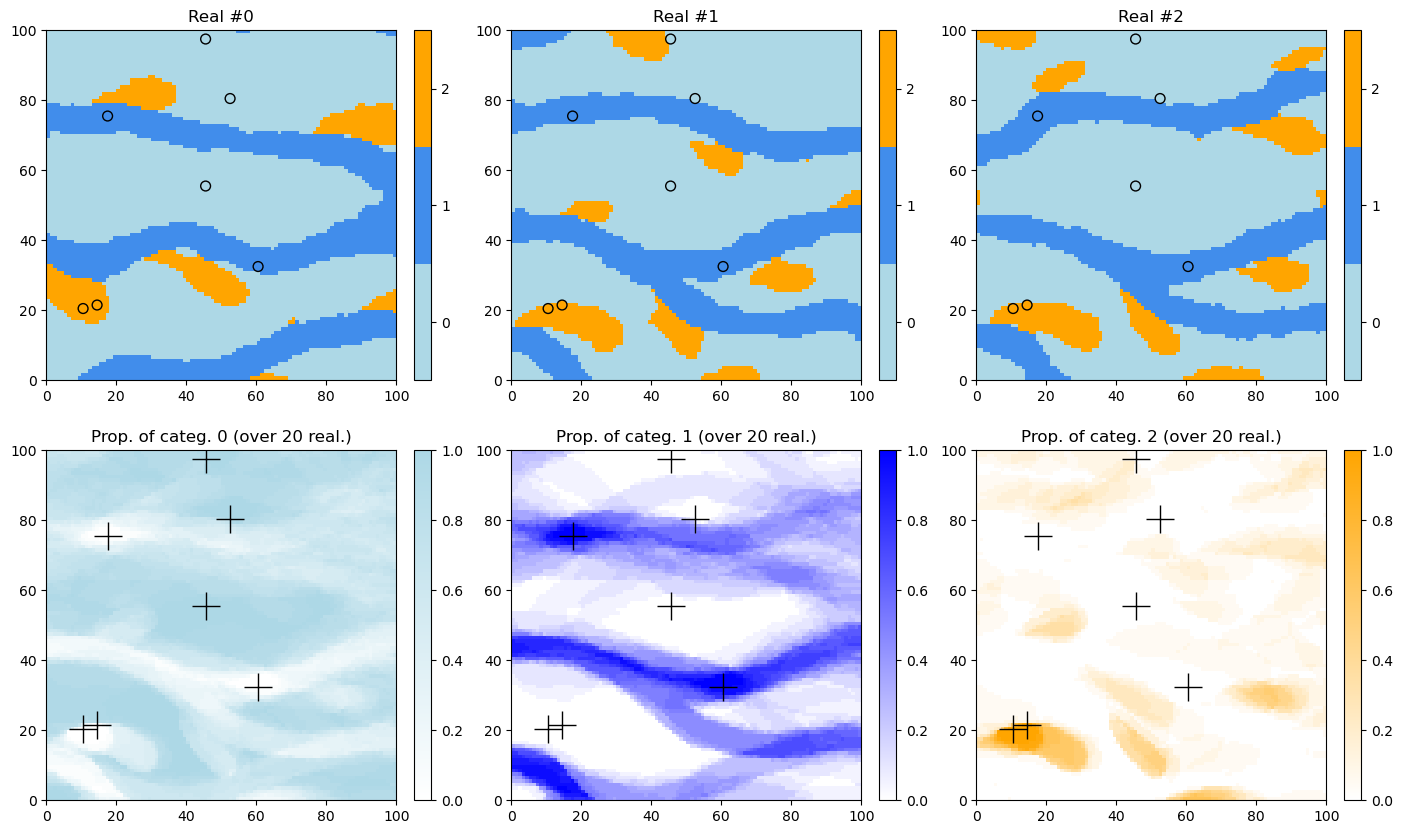

In [18]:
# Retrieve the realizations
sim = deesse_output['sim']

# Gather the nreal realizations into one image
all_sim = gn.img.gatherImages(sim) # all_sim is one image with nreal variables

# Do statistics over all the realizations: compute the pixel-wise proportion for the given categories
all_sim_stats = gn.img.imageCategProp(all_sim, [0, 1, 2])

# Display
plt.subplots(2, 3, figsize=(17,10)) # 2 x 3 sub-plots
for i in range(3):
    plt.subplot(2, 3, i+1) # select next sub-plot
    gn.imgplot.drawImage2D(sim[i], categ=True, categCol=col, title='Real #{}'.format(i)) # plot real #i
    plt.scatter(hd.x(), hd.y(), marker='o', s=50, 
                color=hd_col, edgecolors='black', linewidths=1) # add hard data points
for i in range(3):
    plt.subplot(2, 3, i+4) # select next sub-plot
    gn.imgplot.drawImage2D(all_sim_stats, iv=i, cmap=cmap[i],
                           title='Prop. of categ. {} (over {} real.)'.format(i, nreal))
    plt.plot(hd.x(), hd.y(), '+', c='black', markersize=20) # add hard data points
plt.show()

## 3D example

Same principles. For plotting in 3D, one can use the module `geone.imgplot3d`, based on the package `pyvista`.

In [19]:
import pyvista as pv

pv.set_jupyter_backend('static') # to get static plots within the jupyter notebook

### Read the 3D TI

In [20]:
ti3d = gn.img.readImageGslib('ti_3d.gslib')

### 3D plots 
The following functions can be used:
- `geone.imgplot3d.drawImage3D_volume`: 3D plot of *volumes* (smooth interpolation on the vertex of the cells)
- `geone.imgplot3d.drawImage3D_surface`: 3D plot of *surfaces* (values at cells are plotted)
- `geone.imgplot3d.drawImage3D_slice`: 3D plot of *slices* (planes)

### Remark
The figure are generated by using the package `pyvista`. 

In a notebook, the *plotter* is automatically set in *off screen* mode. To force a pop-up window with an interactive figure in a notebook see the second cell below (uncomment the first line and run the cell).

The camera position `cpos` can be specified, it consists of a list of three 3-tuples (`None` for default), `cpos=[camera_location, focus_point, viewup_vector]`, with
- `camera_location`: (tuple of length 3) camera location ("eye")
- `focus_point`    : (tuple of length 3) focus point
- `viewup_vector`  : (tuple of length 3) viewup vector (vector attached to the "head" and pointed to the "sky"), in principle: *(focus_point - camera_location)* is orthogonal to *viewup_vector*

../src/intel/isl/isl.c:2220: FINISHME: ../src/intel/isl/isl.c:isl_surf_supports_ccs: CCS for 3D textures is disabled, but a workaround is available.


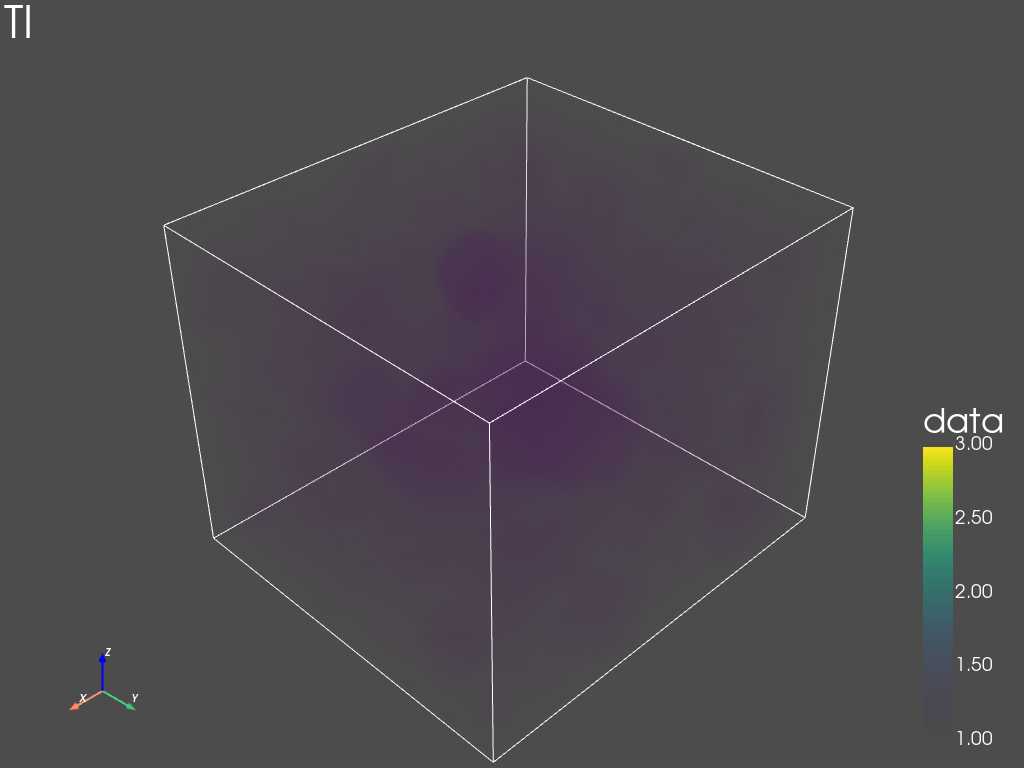

In [21]:
# figure in off screen mode
gn.imgplot3d.drawImage3D_volume(ti3d, scalar_bar_kwargs={'vertical':True}, text='TI')

In [22]:
%%script false --no-raise-error # skip this cell! (comment this line to run the cell)

pp = pv.Plotter(notebook=False) # open a plotter and specifying 'notebook=False'
gn.imgplot3d.drawImage3D_volume(ti3d, plotter=pp,scalar_bar_kwargs={'vertical':True}, text='TI')
pp.show() # open a pop-up window (interactive plot),
          # after closing the pop-up window, the position of the camera is retrieved in output.

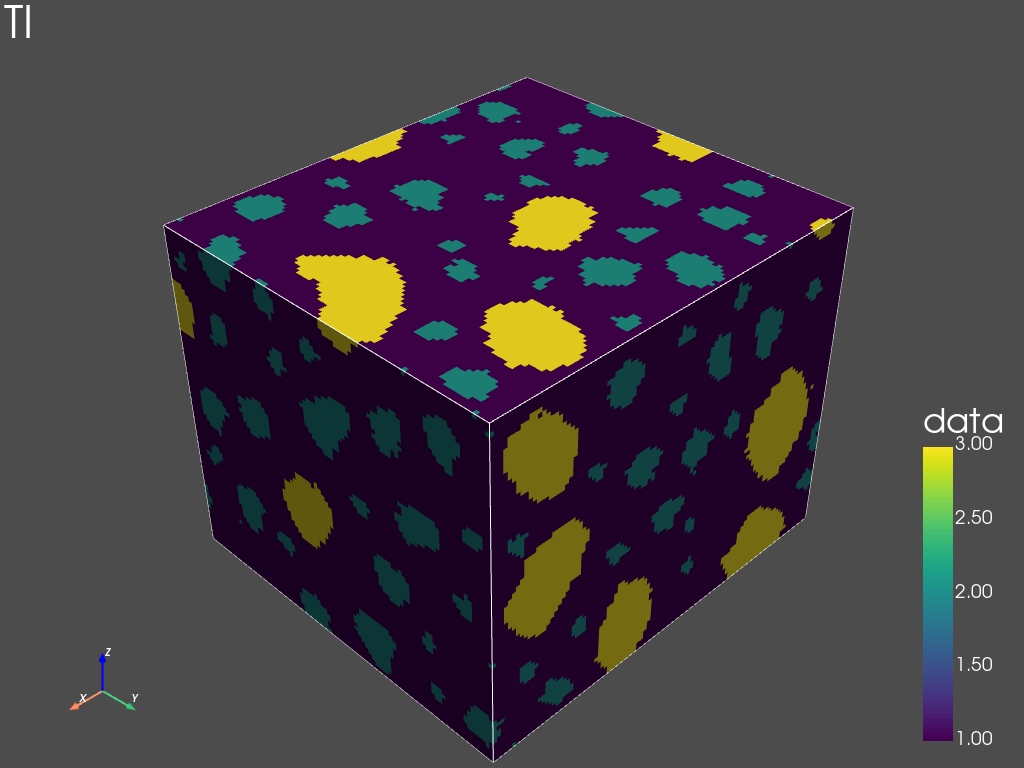

In [23]:
gn.imgplot3d.drawImage3D_surface(ti3d, text='TI', scalar_bar_kwargs={'vertical':True})

In [24]:
facies = ti3d.get_unique()
facies

[1.0, 2.0, 3.0]

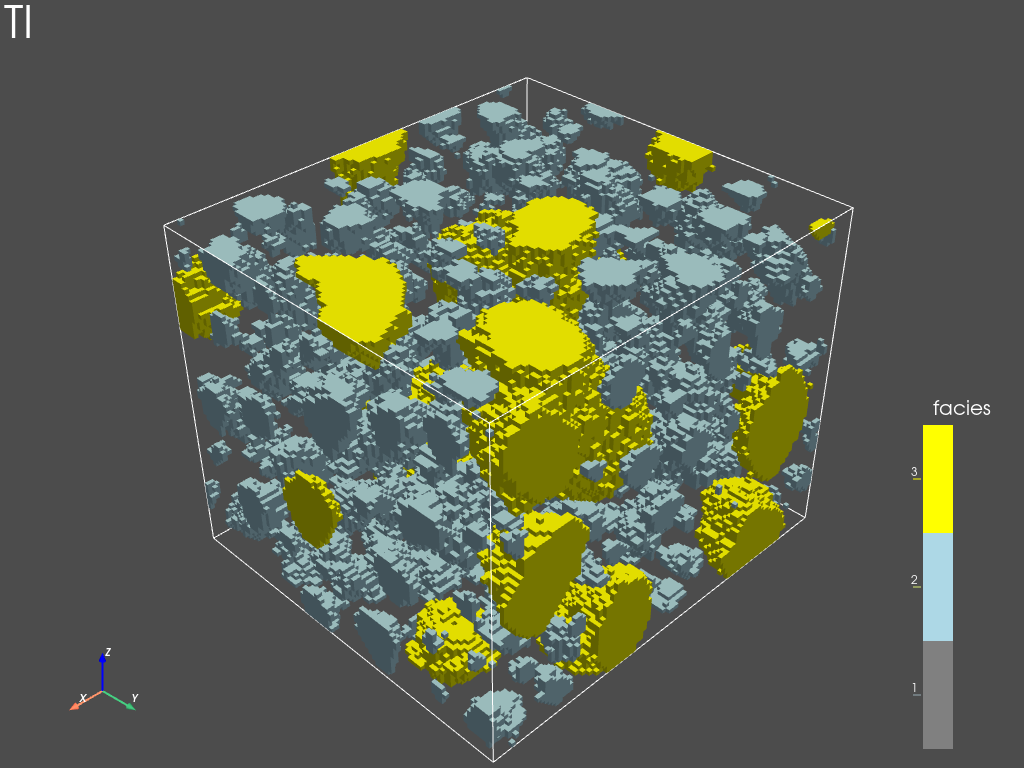

In [25]:
# Customization of the output: 
#    - filter out the plotted values
#    - use (automatic) custom scalar (color) bar for categories with given colors
#    - set title for the scalar bar
colors = ['gray', 'lightblue', 'yellow'] # colors for each category /facies
gn.imgplot3d.drawImage3D_surface(ti3d, filtering_value=[2,3], 
    custom_scalar_bar_for_equidistant_categories=True, 
    custom_colors=colors,
    scalar_bar_kwargs={'title':'facies','title_font_size':20, 'vertical':True},
    text='TI')

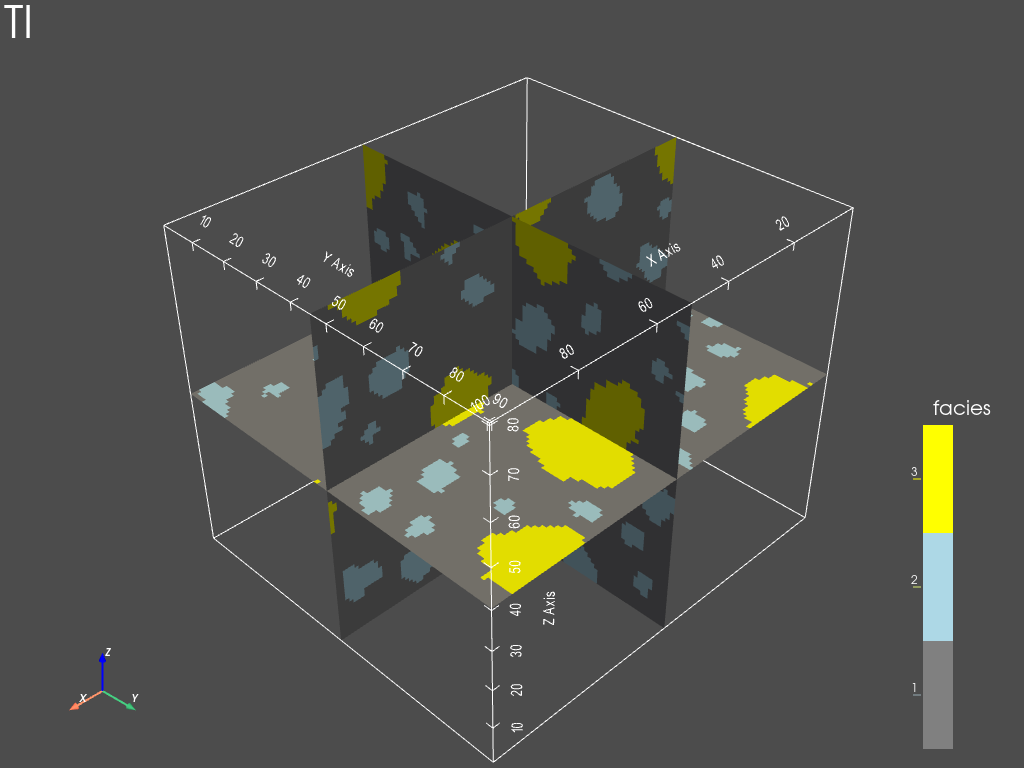

In [26]:
# Slices orthogonal to the axes, going through the center of the images
cx = ti3d.ox + 0.5 * ti3d.nx * ti3d.sx # center along x
cy = ti3d.oy + 0.5 * ti3d.ny * ti3d.sy # center along y
cz = ti3d.oz + 0.5 * ti3d.nz * ti3d.sz # center along z

gn.imgplot3d.drawImage3D_slice(ti3d, slice_normal_x=cx, slice_normal_y=cy, slice_normal_z=cz,
    custom_scalar_bar_for_equidistant_categories=True, 
    custom_colors=colors,
    show_bounds=True,   # add bounds (axis with graduation)
    scalar_bar_kwargs={'title':'facies','title_font_size':20, 'vertical':True},
    text='TI')

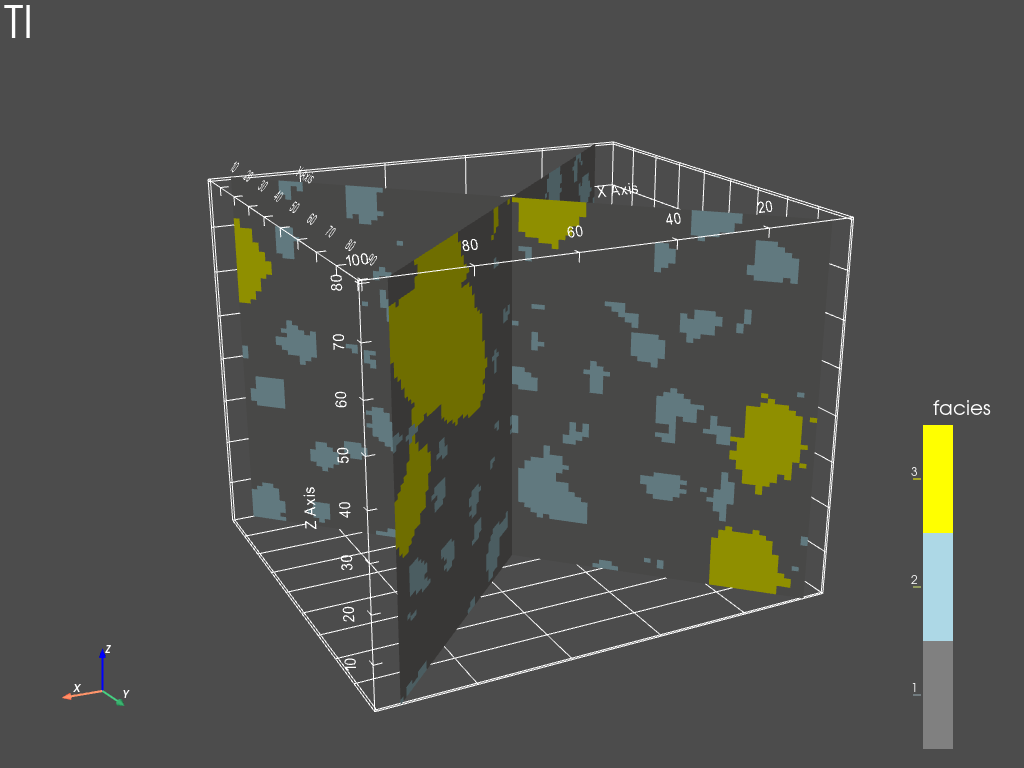

In [27]:
# "Custom" slice defined by the normal vector and a point of the plane
gn.imgplot3d.drawImage3D_slice(ti3d, slice_normal_custom=[[(1, 1, 0), (cx, cy, cz)], [(1, -1, 0), (cx, cy, cz)]],
    custom_scalar_bar_for_equidistant_categories=True, 
    custom_colors=colors,
    show_bounds=True, bounds_kwargs={'grid':True}, # add bounds with grid
    scalar_bar_kwargs={'title':'facies','title_font_size':20, 'vertical':True},
    text='TI',
    cpos = (1, 2, 0.8) # set the position of the camera
)

### Do a simulation with deesse (3D, unconditional, with pyramids)

In [28]:
# Set input for deesse
pyrGenParams = gn.deesseinterface.PyramidGeneralParameters(
    npyramidLevel=2,
    kx=[2, 2], ky=[2, 2], kz=[2, 2]
)

pyrParams = gn.deesseinterface.PyramidParameters(
    nlevel=2,
    pyramidType='categorical_auto'
)

nreal = 1

deesse_input = gn.deesseinterface.DeesseInput(
    nx=60, ny=60, nz=60,
    nv=1, varname='code',
    nTI=1, TI=ti3d,
    nneighboringNode=24,
    distanceThreshold=0.05,
    maxScanFraction=0.25,
    pyramidGeneralParameters=pyrGenParams,
    pyramidParameters=pyrParams,
    npostProcessingPathMax=1,
    seed=444,
    nrealization=nreal)

# Run deesse 
deesse_output = gn.deesseinterface.deesseRun(deesse_input)

DeeSse running... [VERSION 3.2 / BUILD NUMBER 20221014 / OpenMP 19 thread(s)]
* checking out license OK.
DeeSse run complete


### Plot the results

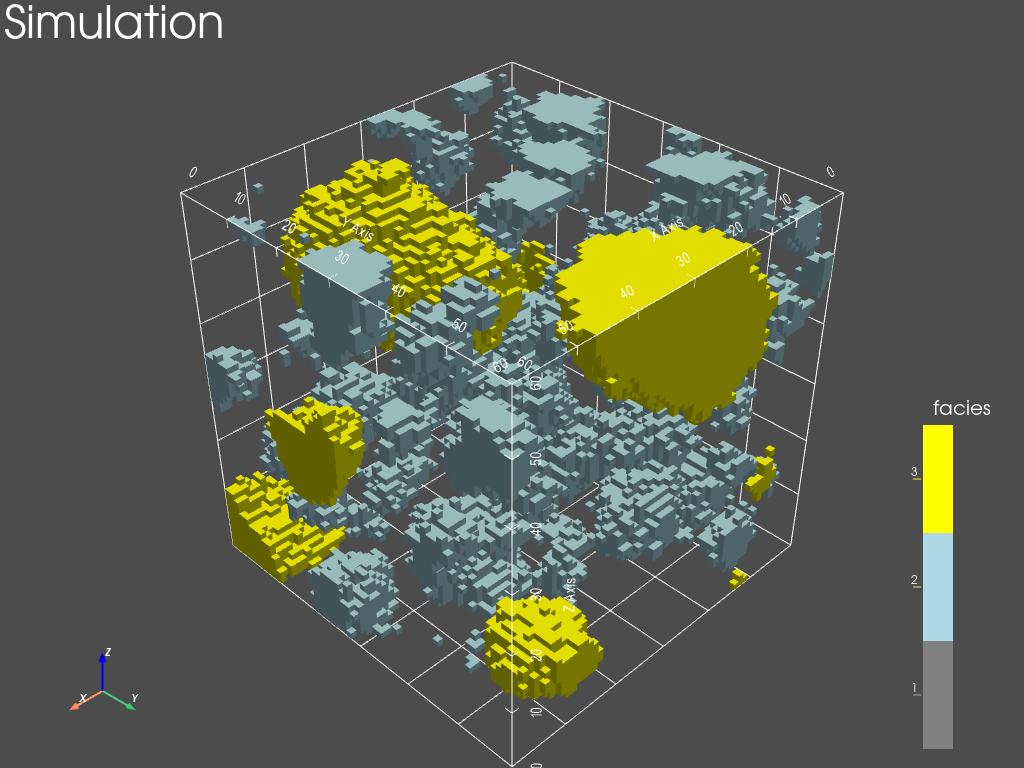

In [29]:
# Retrieve the realization
sim = deesse_output['sim']

# Plot
gn.imgplot3d.drawImage3D_surface(sim[0], filtering_value=[2,3], 
    custom_scalar_bar_for_equidistant_categories=True, 
    custom_colors=colors,
    show_bounds=True, bounds_kwargs={'grid':True},
    scalar_bar_kwargs={'title':'facies','title_font_size':20, 'vertical':True},
    text='Simulation')